# Estimation using pyPESTO
In this notebook we reproduce the parameter estimation with parameters on a $\log_{10}$ scale.

In [24]:
import os
import importlib
import pandas as pd

import amici
import amici.plotting
import matplotlib.pyplot as plt
import numpy as np 
import petab 

import pypesto
import pypesto.optimize as optimize
import pypesto.petab
import pypesto.visualize as visualize

### Import the PEtab model to pyPESTO and AMICI

In [25]:
model_name= "Spoegler_conversionReaction"
param_scale= "log10"


# the yaml file includes all important links to other files
yaml_config ="petab/"+param_scale+"/"+model_name+".yaml"
# create a petab problem
petab_problem = petab.Problem.from_yaml(yaml_config)

# import to amici
importer = pypesto.petab.PetabImporter(petab_problem)
importer.compile_model()

model = importer.create_model() 

# model properties
print("Model parameters:", list(model.getParameterIds()), "\n")
print("Model constant parameters:", list(model.getFixedParameterIds()), "\n")
print("Model outputs:    ", list(model.getObservableIds()), "\n")
print("Model states:     ", list(model.getStateIds()), "\n")

2022-05-02 12:53:05.156 - amici.petab_import - INFO - Importing model ...
2022-05-02 12:53:05.161 - amici.petab_import - INFO - Model name is 'Sp_gler_ConversionReaction'.
Writing model code to '/home/vinc777/python_projects/moses/spoegler_model_reduction/amici_models/Sp_gler_ConversionReaction'.
2022-05-02 12:53:05.163 - amici.petab_import - INFO - Species: 2
2022-05-02 12:53:05.164 - amici.petab_import - INFO - Global parameters: 3
2022-05-02 12:53:05.167 - amici.petab_import - INFO - Reactions: 0
2022-05-02 12:53:05.180 - amici.petab_import - INFO - Observables: 1
2022-05-02 12:53:05.180 - amici.petab_import - INFO - Sigmas: 1
2022-05-02 12:53:05.183 - amici.petab_import - DEBUG - Adding output parameters to model: OrderedDict([('noiseParameter1_observed_B', None)])
2022-05-02 12:53:05.186 - amici.petab_import - DEBUG - Adding initial assignments for []
2022-05-02 12:53:05.188 - amici.petab_import - DEBUG - Condition table: (1, 0)
2022-05-02 12:53:05.189 - amici.petab_import - DEBUG

running AmiciInstall
Adding OpenMP flags...
hdf5.h found in /usr/include/hdf5/serial
libhdf5.a found in /usr/lib/x86_64-linux-gnu/hdf5/serial
running build_ext
Changed extra_compile_args for unix to ['-fopenmp', '-std=c++14']
building 'Sp_gler_ConversionReaction._Sp_gler_ConversionReaction' extension
Testing SWIG executable swig4.0... SUCCEEDED.
swigging swig/Sp_gler_ConversionReaction.i to swig/Sp_gler_ConversionReaction_wrap.cpp
swig4.0 -python -c++ -modern -outdir Sp_gler_ConversionReaction -I/home/vinc777/.local/lib/python3.8/site-packages/amici/swig -I/home/vinc777/.local/lib/python3.8/site-packages/amici/include -o swig/Sp_gler_ConversionReaction_wrap.cpp swig/Sp_gler_ConversionReaction.i
Deprecated command line option: -modern. This option is now always on.
creating build
creating build/temp.linux-x86_64-3.8
creating build/temp.linux-x86_64-3.8/swig
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat 

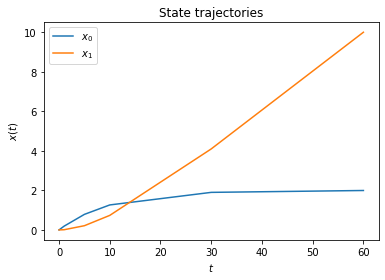

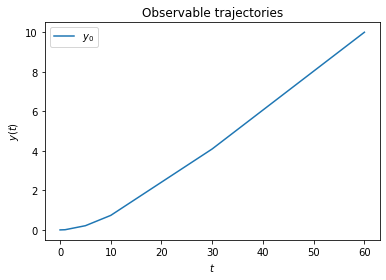

In [26]:
solver = importer.create_solver(model)
model.setTimepoints([0,1,5,10,30,60])


# Run simulation using default model parameters and solver options
rdata = amici.runAmiciSimulation(model, solver)

# get simulated data
simulations = rdata.x

# plot simulated trajectories
amici.plotting.plotStateTrajectories(rdata)
amici.plotting.plotObservableTrajectories(rdata)

### Optimization
Next we do a simple optimization without using priors.

In [27]:
# enable sensitivities 
solver.setSensitivityOrder(amici.SensitivityOrder_first)
solver.setSensitivityMethod(amici.SensitivityMethod_forward)
model.requireSensitivitiesForAllParameters()

# create objective function from amici model
objective = importer.create_objective(model, solver)

In [28]:
print('optimal x = ', petab_problem.x_nominal)
print('optimal lh value', objective(np.log10(petab_problem.x_nominal)))

optimal x =  [0.2, 0.1, 0.0, 0.15]
optimal lh value -3.418410586028321


In [29]:
# create optimizer object
optimizer = optimize.ScipyOptimizer(method="L-BFGS-B")

# create problem object
problem = importer.create_problem()

# do the optimization
n_starts= 100
result = optimize.minimize(
        problem=problem, optimizer=optimizer, n_starts=n_starts, filename=None
)

Using existing amici model in folder /home/vinc777/python_projects/moses/spoegler_model_reduction/amici_models/Sp_gler_ConversionReaction.
  2%|▏         | 2/100 [00:02<02:02,  1.25s/it][Warning] AMICI:CVODES:CVode:TOO_MUCH_WORK: AMICI ERROR: in module CVODES in function CVode : At t = 56.4154, mxstep steps taken before reaching tout. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 56.415443:
AMICI failed to integrate the forward problem

  8%|▊         | 8/100 [00:06<01:08,  1.34it/s][Warning] AMICI:CVODES:CVode:TOO_MUCH_WORK: AMICI ERROR: in module CVODES in function CVode : At t = 15.7841, mxstep steps taken before reaching tout. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 15.784103:
AMICI failed to integrate the forward problem

 12%|█▏        | 12/100 [00:08<01:07,  1.30it/s][Warning] AMICI:CVODES:CVode:TOO_MUCH_WORK: AMICI ERROR: in module CVODES in function CVode : At t = 51.2318, mxstep steps taken before reaching tout. 
[Warning] AMI

#### Results

In [35]:
# print results
best_result=result.optimize_result.as_list("x")[0]["x"]
print('best parameter: ', best_result)
print('best likelihood value: ', problem.objective(best_result))

best parameter:  [-0.53138846 -1.24437818 -2.7552477  -1.03229976]
best likelihood value:  -5.748130232114914


<AxesSubplot:title={'center':'Waterfall plot'}, xlabel='Ordered optimizer run', ylabel='Function value'>

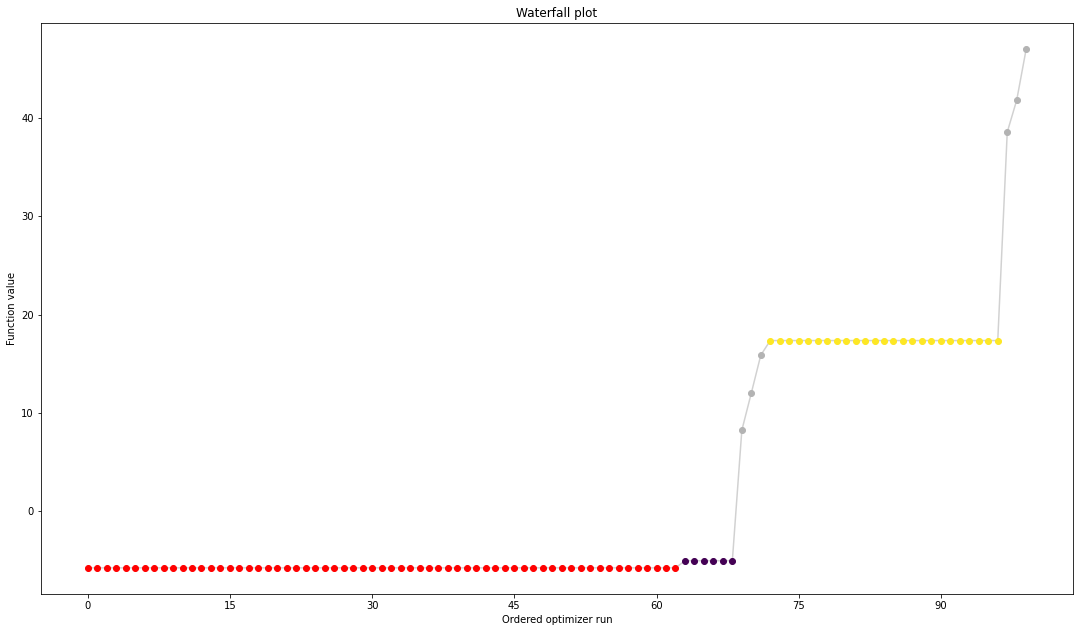

In [31]:
# waterfall plot
fvals = result.optimize_result.get_for_key("fval")
fval = np.array(fvals)
fval=fval[fval < 1e2]
visualize.waterfall_lowlevel(fval, scale_y='lin')

Next we look on the number of converged runs.

In [32]:
# converged means close to the best result up to a threshold

threshold = 1e-2
n_compares = len(result.optimize_result.as_list("x"))
n_converged = 0
for i in range(0, n_compares):
    compare_result = result.optimize_result.as_list("x")[i]["x"]
    converged = (np.abs((compare_result - best_result)) < (threshold * len(compare_result))).all()
    if converged:
        n_converged += 1

print("Number of converged runs: ", n_converged)

Number of converged runs:  63


<AxesSubplot:title={'center':'Estimated parameters'}, xlabel='Parameter value', ylabel='Parameter'>

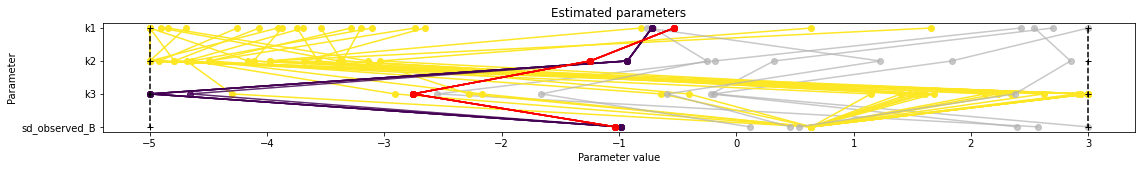

In [33]:
visualize.parameters(result)

In [34]:
results =   [['theta1', petab_problem.x_nominal[0], best_result[0], 0.2, 10**best_result[0], objective(np.log10(petab_problem.x_nominal)), objective(best_result)],
             ['theta2', petab_problem.x_nominal[1], best_result[1], 0.1, 10**best_result[1], objective(np.log10(petab_problem.x_nominal)), objective(best_result)],
             ['theta3', petab_problem.x_nominal[2], best_result[2], 0.0, 10**best_result[2], objective(np.log10(petab_problem.x_nominal)), objective(best_result)],
             ['sigma', petab_problem.x_nominal[3], best_result[3], 0.15, 10**best_result[3], objective(np.log10(petab_problem.x_nominal)), objective(best_result)]]

results_df = pd.DataFrame(results, columns=['Parameter', 'Nominal', 'best', 'nominal-linear', 'best-linear', 'nominal-likelihood', 'likelihood'])

print(results_df)

results_df.to_csv("estimation_results/"+param_scale+".csv", index=False)

  Parameter  Nominal      best  nominal-linear  best-linear  \
0    theta1     0.20 -0.531388            0.20     0.294179   
1    theta2     0.10 -1.244378            0.10     0.056967   
2    theta3     0.00 -2.755248            0.00     0.001757   
3     sigma     0.15 -1.032300            0.15     0.092833   

   nominal-likelihood  likelihood  
0           -3.418411    -5.74813  
1           -3.418411    -5.74813  
2           -3.418411    -5.74813  
3           -3.418411    -5.74813  
